In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_digits

%matplotlib inline

np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Qtd Digits:  1797


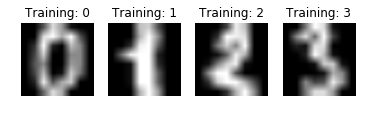

In [515]:
digits = load_digits()
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap='gray', interpolation='bilinear')
    plt.title('Training: %i' % label)

n_samples = len(digits.images)
print('Qtd Digits: ', n_samples)

X = digits.images.reshape((n_samples, -1))
X = X / 255.
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X[:30], y[:30], test_size=0.3, random_state=0)

In [600]:
import numpy as np
import pandas as pd


class Layer:
    
    def __init__(self, name=1, inputs=1, outputs=1, activation='sigmoid'):
        self._name = name
        self.W = np.random.rand(inputs, outputs) * np.sqrt(2 / (outputs + inputs))
        self.B = np.zeros((1, outputs))
        self.A = np.zeros((inputs, self.W.shape[0]))
        
        if activation == 'sigmoid':
            self._activation = self._sigmoid
        elif activation == 'relu':
            self._activation = self._relu
        elif activation == 'softmax':
            self._activation = self._softmax
    
    def __str__(self):
        return f'Layer: {self._name}'
    
    def __repr__(self):
        return f'Layer: {self._name}'
    
    def _sigmoid(self, Z, deriv=False):
        if deriv:
            return Z * (1 - Z)
        return 1. / (1 + np.exp(-Z))
    
    def _relu(self, Z, deriv=False):
        if deriv:
            return 1. * (Z > 0)
        return np.maximum(0, Z)

    def _softmax(self, Z, deriv=False):
        y = np.exp(Z)
        return y / np.sum(y, axis=1, keepdims=True)

    def forward(self, Z):
        self.A = self._activation(Z.dot(self.W) + self.B)
        return self.A

    def E_grad(self, E):
        # Avoid exploding gradients
        return np.clip(E * self._activation(self.A, deriv=True), -1, 1)


class NeuralNetwork:

    def __init__(self, layers, X, y, loss='MSE'):
        # That is why we seed the generator - to make sure that we always get the same random numbers.
        np.random.seed(0)
        
        # Initialization
        self._layers = layers
        self._X = X
        self._y = y
        
        self._loss = self._mse
        if loss == 'cross_entropy':
            self._loss = self._cross_entropy
            self._y = self.one_hot_encode(self._y)
        
        self._total_samples = 1. / self._y.shape[0]
        self._total_layers = len(layers)
        self._mem_weights = {}

    def one_hot_encode(self, y):
        return pd.get_dummies(y).as_matrix()
    
    def _mse(self, E):
        return np.sum(E**2) * self._total_samples

    def _cross_entropy(self, E):
        # return -(np.sum(self._y * np.log(E.clip(min=1e-10))) * self._total_samples)
        E = E.clip(min=1e-10)
        y = self._y
        return np.sum(np.dot(np.log(E), y.T) + np.dot(np.log(1-E), (1-y).T)) * self._total_samples
    
    def _forward(self, Z):
        for i, layer in enumerate(self._layers):
            Z = layer.forward(Z)
        return Z

    def _backward(self, E):
        m = self._total_samples
        E_prev = E
        # First Layer
        last_layer = self._layers[-1]
        delta = E_prev
        self._mem_weights[f'{last_layer}'] = (
            m * self._layers[-2].A.T.dot(delta),  # dW 
            m * np.sum(delta, axis=0)  # dB
        )
        
        # Hidden Layers
        k = len(self._layers)-2
        for layer in reversed(self._layers[1:len(self._layers)-1]):
            E_prev = E_prev.dot(last_layer.W.T)
            last_layer = layer
            delta = last_layer.E_grad(E_prev)
            self._mem_weights[f'{last_layer}'] = (
                m * self._layers[(k-1)].A.T.dot(delta),  # dW 
                m * np.sum(delta, axis=0)  # dB
            )
            k -= 1

        # Last Layer
        E_prev = E_prev.dot(last_layer.W.T)
        last_layer = self._layers[0]
        delta = last_layer.E_grad(E_prev)
        self._mem_weights[f'{last_layer}'] = (
            m * self._X.T.dot(delta),  # dW
            m * np.sum(delta, axis=0)  # dB
        )

    def _update_weights(self, lr):
        for layer in reversed(self._layers):
            W, B = self._mem_weights[f'{layer}']
            layer.W -= lr * W
            layer.B -= lr * B

    def train(self, epochs=1500, lr=1e-3):
        error_step = []
        total_expected_error = 0

        for ep, epoch in enumerate(range(epochs)):
            Z = self._X.copy()

            # Forward
            Z = self._forward(Z)
            
            # Loss
            E = Z - self._y  # error
            # E = -(np.divide(self._y, Z) - np.divide(1 - self._y, 1 - Z))
            
            # Backward / Backprop
            self._backward(E)

            # Update weights and bias
            self._update_weights(lr)

            # Cost
            total_error = self._loss(E)
            print(total_error)
            if np.abs(total_expected_error-total_error) < 1e-15:
                return np.array(error_step)
            total_expected_error = total_error
            error_step.append(total_error)
        return np.array(error_step)

    def predict(self, Z):
        Z = self._forward(Z)
        if self._loss == self._cross_entropy:
            return np.argmax(Z, axis=1)
        return Z

[2 5 6 8 4 3 0 1 9 6 4 8 9 9 7 5 3 0 1 5 2]
-112.46853451104893
-112.42896525883296
-112.39232322753759
-112.35827637318876
-112.32656698552223
-112.29699336846866
-112.26939588067349
-112.24364616369382
-112.21963875958951
-112.19728456612579
-112.17650574123505
-112.1572317767002
-112.13939653230848
-112.12293606808487
-112.10778714198433
-112.09388625950344
-112.0811691742902
-112.06957074797745
-112.05902508520055
-112.04946586736854
-112.0408268169358
-112.03304223287955
-112.02604754770978
-112.01977986628755
-112.0141784565696
-112.00918517169079
-112.00474479115945
-112.00080527609632
-111.99731793924127
-111.99423753484216
-111.99152227659381
-111.98913379364762
-111.98703703555562
-111.98520013704949
-111.9835942530004
-111.98219337294509
-111.98097412337019
-111.9799155646467
-111.97899898821065
-111.97820771835909
-111.97752692192296
-111.9769434281147
-111.97644556003601
-111.97602297866884
-111.97566653964782
-111.97536816271375
-111.97512071345162
-111.97491789671416
-11

-118.2668031380051
-114.10992507587397
-118.42488724029947
-114.10639085825734
-118.5520805929298
-114.11480447175144
-118.58693627725714
-114.17635097249659
-118.75843419574362
-114.20128908972488
-118.80601251117714
-114.2371337212929
-118.90618443493244
-114.28794031360766
-119.09100003840157
-114.26858196900595
-119.03851874997005
-114.37317206526616
-119.25595705026176
-114.36604464150068
-119.28645012730348
-114.42496775075652
-119.44597309760752
-114.44616219662782
-119.4990420462088
-114.51500036542042
-119.64414063646927
-114.50858711777583
-119.74967879116996
-114.5737837797459
-119.83057204672664
-114.60205363679371
-119.99294036517003
-114.6681205047615
-120.0412183165216
-114.67957424837692
-120.15218566490877
-114.73602156266615
-120.26426824079148
-114.76867658910001
-120.38497163787433
-114.80355527845529
-120.45228031998937
-114.86476994319764
-120.62496967424613
-114.8787351236524
-120.72896010639515
-114.93240422070677
-120.81458038763074
-114.98234171470877
-120.957

-128.51284484410317
-146.41505526507427
-129.63885007191158
-147.65144385253603
-128.8434362538691
-146.97386232268082
-129.62583359699514
-147.58296993217948
-129.14363401941156
-147.16241988202475
-129.98043891866007
-148.4688107064343
-129.17308016750684
-147.43027281978232
-130.42634617374736
-148.49441765157823
-129.68691542798308
-148.0203452733285
-130.45102405705802
-148.67958627263698
-130.07585297536215
-148.88162574940498
-129.96424701067428
-148.41826122588756
-130.46819878424296
-148.90897229264453
-130.46252338031368
-149.0591467069312
-130.4540506593824
-149.2677380173276
-130.75767553080317
-149.5394124873583
-130.8698824502327
-149.74589104737322
-130.65707454373845
-149.75474629038507
-130.88830755747819
-149.99125185680717
-130.9401642855237
-149.96425623110028
-131.50598382397672
-150.79912160703947
-130.85552318772258
-149.98968450815593
-131.5814614766604
-151.0153816726031
-130.97220005968984
-150.19198800048645
-132.00209963851557
-151.55465871475135
-130.992215

-180.97515108160803
-155.2213324987426
-180.74552051761466
-155.67769812304581
-180.78459105359207
-155.96345151849098
-181.17162833965259
-155.42121045739134
-180.9743143796678
-156.356909255108
-181.36137521245797
-155.6333841790725
-181.13721405480152
-156.59218146027098
-181.58615789529514
-156.07016099116169
-181.39951321112406
-156.7695914752335
-181.6935508548285
-156.52924183643975
-181.72353716638918
-156.67377105718197
-181.77847206265895
-157.02845282166453
-181.97671662727063
-156.18339299882322
-181.80204386526458
-156.8720428577003
-182.08260246196667
-156.92652707534572
-182.2001279992778
-157.1081301248295
-182.0511791241239
-156.86279880682466
-182.48856797500252
-156.83342141765382
-182.2072816245129
-157.44077135526
-182.5797648782754
-157.24194789878857
-182.28237635407143
-158.3019847207469
-182.85107667514703
-157.204444306991
-182.57546692410398
-157.78698512527907
-182.94321798837808
-157.58131101791673
-182.80474938986995
-158.11482063245194
-183.0715241394551


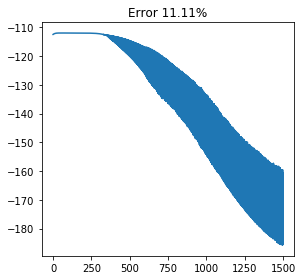

In [599]:
final_error = []
better_acc = 0

layers = (
    Layer(1, inputs=64, outputs=16, activation='relu'),
    Layer(2, inputs=16, outputs=16, activation='relu'),
    Layer(3, inputs=16, outputs=16, activation='relu'),
    Layer(4, inputs=16, outputs=10, activation='softmax')
)

print(y_train)
md = NeuralNetwork(layers, X_train.copy(), y_train.copy(), loss='cross_entropy')
error = md.train(lr=1e-1)
print('-' * 100)
y_pred = md.predict(X_test.copy())

print('y_pred: ', y_pred)
print('result: ',y_test)
acc = np.round((np.sum(y_pred == y_test) / len(y_test)) * 100, 2)
if acc > better_acc:
    better_acc = acc
final_error = error
print(f'Acurácia: {acc}%')

if len(final_error):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title(f'Error {better_acc}%')
    plt.plot(range(len(final_error)), final_error)
    plt.tight_layout()
    plt.show()

In [539]:
classifier = MLPClassifier(
    max_iter=1500,
    solver='sgd',
    batch_size=X_train.shape[0],
    shuffle=False,
    learning_rate_init=1e-1,
    random_state=0
)
classifier.fit(X_train, y_train)

predicted = classifier.predict(X_test)
print(predicted)

print(f'Acurácia: {np.round(classifier.score(X_test, y_test) * 100, 2)}%')
print('-' * 20)
print("Classification report for classifier %s:\n%s\n"
      % (classifier, classification_report(y_test, predicted)))
print("Confusion matrix:\n%s" % confusion_matrix(y_test, predicted))

[6 8 3 0 6 4 4 1 8]
Acurácia: 66.67%
--------------------
Classification report for classifier MLPClassifier(activation='relu', alpha=0.0001, batch_size=21, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.1, max_iter=1500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=False,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False):
             precision    recall  f1-score   support

          0       1.00      1.00      1.00         1
          1       1.00      1.00      1.00         1
          2       0.00      0.00      0.00         1
          3       1.00      1.00      1.00         1
          4       0.50      1.00      0.67         1
          6       0.50      1.00      0.67         1
          7       0.00      0.00      0.00         2
          8       0.50      1.00      0.67         1


/home/rdenadai/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
